In [27]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

In [28]:
FIRST_SIZE = 2
LAST_SIZE = 16

COUNT_TRIES = 10

MAX_DEF_COUNT_ITER = 100000
"""Максимальное количество итераций по-умолчанию"""
DEF_EPS = 0.0001
"""Точность по-умолчанию"""

'Точность по-умолчанию'

In [29]:
df = pd.DataFrame(
    columns=[
        "size",
        "true_value_max",
        "true_value_min",
        "value_max",
        "value_max_time",
        "value_min_def",
        "value_min_def_time",
        "value_min_rel",
        "value_min_rel_time"
    ],
    index=range(1, (LAST_SIZE - FIRST_SIZE + 1) * COUNT_TRIES + 1),
)
df

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Подготовка

In [30]:
def calc(A: np.matrix, b: np.matrix) -> np.matrix:
    if b is None:
        print("Вектор собственного значения не был посчитан")
        return None
    return float((b.T @ A @ b) / (b.T @ b))

# Прямой метод

$x^{(k)} = \dfrac{Ax^{(k - 1)}}{\alpha_{k - 1}}$

$\lambda_{1}(A) = \dfrac{\left( Ax^{(k)}, x^{(k)} \right)}{(x^{(k)}, x^{(k)})} = \dfrac{(x^{(k)})^{T}A^{(k)}x^{(k)}}{(x^{(k)})^{T}x^{(k)}}$, где $|\lambda_1(A)|$ - наибольшее по модулю СЗ

In [31]:
def power_iteration(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1)
    # print("Начальное приближение:", b_k, sep="\n")

    alpha_old = None

    # for _ in range(num_iterations):
    while True:
        b_k1 = np.dot(A, b_k)

        b_k1_norm = np.linalg.norm(b_k1)

        b_k = b_k1 / b_k1_norm

        alpha_new = calc(A, b_k)
        if alpha_old is not None and abs(alpha_new - alpha_old) < epsilon:
            break
        alpha_old = alpha_new

    return b_k, alpha_new

# Обратный метод

## Стандартная версия

In [32]:
def inverse_power_def(
    A: np.matrix,
    epsilon: float = DEF_EPS,
    num_iterations=MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
) -> np.matrix:
    try:
        inv_A = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        print("Вырожденная матрица")
        return None
    # print("Обратная матрица:",inv_A, sep="\n")
    res = power_iteration(
        A=inv_A, epsilon=epsilon, num_iterations=num_iterations, b_k=b_k
    )
    return res[0], 1 / res[1]

In [33]:
# A: np.matrix = np.matrix("1 3 -2 0;"
#                          "1 1 4 7;"
#                          "4 7 11 23;"
#                          "52 66 2 0")  # -0.65
# calc(A, inverse_power_def(A))

## Модификация Релэя

In [34]:
import random


def inverse_power_rel(
    A, epsilon: float = DEF_EPS, num_iterations=MAX_DEF_COUNT_ITER, mu=None, b_k=None
):
    if b_k is None:
        b_k = np.random.rand(
            A.shape[1], 1
        )  # Попробовать близкий к настоящему собственный вектор
    if mu is None:
        mu = random.randint(1, 100)  # Случайное начальное приближение
    #   print("Начальное приближение:", "СЗ:", mu, "СВ:", b_k, sep="\n")

    b_k = b_k / np.linalg.norm(b_k)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    # print(lambda_, lambda_ * x)
    mu = mu + 1 / lambda_
    #   mu = calc(A, b_k)
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

    index = 0
    while err > epsilon and index < num_iterations:
        b_k = y / np.linalg.norm(y)
        y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
        lambda_ = float(np.dot(y.T, b_k))
        mu = mu + 1 / lambda_
        err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)
        index += 1

    return b_k, float(mu)

In [35]:
def rayleigh(A, epsilon = DEF_EPS, mu = None, b_k = None):
  if b_k is None:
      b_k = np.random.rand(A.shape[1], 1) # Попробовать близкий к настоящему собственный вектор
  if mu is None:
    mu = random.randint(1, 100)
  print("R:\n", mu, " ", b_k, "\n")
  
  b_k = b_k / np.linalg.norm(b_k)
  y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
  # print(y)
  # print(x)
  lambda_ = float(np.dot(y.T, b_k))
  # print(lambda_, lambda_ * x)
  mu = mu + 1 / lambda_
  err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  while err > epsilon:
    b_k = y / np.linalg.norm(y)
    y = np.linalg.solve(A - mu * np.eye(A.shape[0]), b_k)
    lambda_ = float(np.dot(y.T, b_k))
    mu = mu + 1 / lambda_
    err = np.linalg.norm(y - lambda_ * b_k) / np.linalg.norm(y)

  return b_k, float(mu)

In [36]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# Сильно зависит от начального приближения
# Не вижу в ней смысла
inverse_power_rel(A)[1]
# calc(A, inverse_power_rel(A)[0])

-1.3738994301856463e-08

## Модификация Арнольди

In [37]:
def arnoldi_iteration(A, n: int, epsilon: float = DEF_EPS, b_k=None):
    """Compute a basis of the (n + 1)-Krylov subspace of the matrix A.

    This is the space spanned by the vectors {b, Ab, ..., A^n b}.

    Parameters
    ----------
    A : array_like
        An m times m array.
    b_k : array_like
        Initial vector (length m).
    n : int
        One less than the dimension of the Krylov subspace, or equivalently the *degree* of the Krylov space. Must be >= 1.

    Returns
    -------
    Q : numpy.array
        An m x (n + 1) array, where the columns are an orthonormal basis of the Krylov subspace.
    h : numpy.array
        An (n + 1) x n array. A on basis Q. It is upper Hessenberg.
    """
    if b_k is None:
        b_k = np.random.rand(A.shape[1], 1).ravel()
    eps = epsilon
    h = np.zeros((n + 1, n))
    Q = np.zeros((A.shape[0], n + 1))
    # Normalize the input vector
    Q[:, 0] = b_k / np.linalg.norm(b_k, 2)  # Use it as the first Krylov vector
    for k in range(1, n + 1):
        v = np.dot(A, Q[:, k - 1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j, k - 1] = np.dot(Q[:, j].conj(), v)
            v = v - h[j, k - 1] * Q[:, j]
        h[k, k - 1] = np.linalg.norm(v, 2)
        if h[k, k - 1] > eps:  # Add the produced vector to the list, unless
            Q[:, k] = v / h[k, k - 1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h

In [38]:
A: np.matrix = np.matrix("1 -2 -1;"
                         "-1 1 1;"
                         "1 0 -1")  # 0, 2, -1
# arnoldi_iteration(A=A, n=3)

# Вычисление

In [39]:
def output(
    A: np.matrix,
    texts: list[str],
    funcs: list,

    num_iterrations: int = MAX_DEF_COUNT_ITER,
    b_k: np.matrix = None,
    mu: float = None,
) -> tuple[np.matrix, list[float | None]]:

    abs_v = np.abs(np.linalg.eigvals(A))

    abs_v_max = np.max(abs_v)

    abs_v_min = np.min(abs_v)
    # print(

    #     "Собственные значения матрицы A",

    #     f"Максимальное: {abs_v_max}",
    #     f"Минимальное: {abs_v_min}",
    #     sep="\n",
    # )


    # print("========")

    mass_eval = []


    for text, f in zip(texts, funcs):
        start_time = time()
        # print(text)
        if f.__name__ != inverse_power_rel.__name__:
            evec, eval = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # evec = f(A=A, num_iterations=num_iterrations, b_k=b_k)
            # eval = calc(A, evec)
        else:
            evec, eval = f(A=A, b_k=b_k, mu=mu)
        stop_time = time()
        # print("========")
        mass_eval.append(abs(eval))
        mass_eval.append(stop_time - start_time)


    # print(text_1)

    # first_evec = f_1(A=A, num_iterations=num_iterrations, b_k=b_k)

    # first_eval = calc(A, first_evec)
    # print("========")


    # print(text_2)

    # if f_2.__name__ != inverse_power_rel.__name__:

    #     second_evec = f_2(A=A, num_iterations=num_iterrations, b_k=b_k)

    #     second_eval = calc(A, second_evec)

    # else:

    #     second_evec, second_eval = f_2(A=A, b_k=b_k, mu=mu)
    # print("========")

    # print(


    #     "Собственные векторы:",

    #     f"{text_1}:",
    #     first_evec,


    #     f"{text_2}:",

    #     second_evec,

    #     sep="\n",
    # )
    # print(


    #     "Собственные значения:",

    #     f"{text_1}: {first_eval}",

    #     f"{text_2}: {second_eval}",

    #     sep="\n",
    # )


    return A.shape[0], abs_v_max, abs_v_min, *mass_eval

In [40]:
def generate_non_singular(n):
    while True:
        # Генерируем случайную матрицу n x n
        matrix = np.random.rand(n, n)  # Вы можете использовать np.random.randint для целых чисел.
        if np.linalg.det(matrix) != 0:  # Проверяем, что определитель не равен нулю
            return matrix

In [ ]:
import numpy as np
# texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Арнольди)"]
# funcs = [power_iteration, inverse_power_def, arnoldi_iteration]
texts = ["Прямые итерации", "Обратные итерации (обычные)", "Обратные итерации (Релэя)"]
funcs = [power_iteration, inverse_power_def, inverse_power_rel]
# texts = ["Прямые итерации", "Обратные итерации (обычные)"]
# funcs = [power_iteration, inverse_power_def]
mass = []

for i in range(FIRST_SIZE, LAST_SIZE + 1):
    print(f"Current size:{i}")
    for j in range(COUNT_TRIES):
        print(j + 1)
        matr = generate_non_singular(i)
        df.iloc[(i - FIRST_SIZE) * COUNT_TRIES + j] = output(matr, texts, funcs)
    print()

df["delta_max"] = abs(df["true_value_max"] - df["value_max"])
df["delta_min_def"] = abs(df["true_value_min"] - df["value_min_def"])
df["delta_min_rel"] = abs(df["true_value_min"] - df["value_min_rel"])

df

Current size:2
1
2
3
4
5
6
7
8
9
10

Current size:3
1
2
3
4
5
6
7
8
9
10

Current size:4
1
2
3
4
5
6
7
8
9
10

Current size:5
1
2


In [16]:
df.sort_values("delta_max", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
105,12,5.830636,0.141411,5.828956,0.0,0.141411,0.001,5.830636,0.0,0.00168,0.000001,5.689225
60,7,3.24003,0.316056,3.239335,0.0,22.699929,0.895675,3.24003,0.0,0.000695,22.383873,2.923974
15,3,1.475175,0.063086,1.47481,0.0,0.063086,0.0,1.475175,0.0,0.000365,0.0,1.412088
65,8,3.813349,0.354423,3.813102,0.0,0.35442,0.0,3.813349,0.0,0.000247,0.000003,3.458926
66,8,3.919406,0.132577,3.919603,0.0,0.132576,0.001006,3.919406,0.0,0.000197,0.000001,3.78683
94,11,5.200858,0.225036,5.200713,0.0,0.631937,0.123689,5.200858,0.0,0.000145,0.406901,4.975822
75,9,4.655062,0.288768,4.65493,0.0,0.21213,5.707415,4.655062,0.0,0.000132,0.076638,4.366294
108,12,6.11555,0.048797,6.115672,0.0,0.053042,1.557847,6.11555,0.0,0.000123,0.004246,6.066753
90,10,4.500971,0.092715,4.500873,0.0,0.092716,0.0,4.500971,0.0,0.000098,0.0,4.408255
28,4,1.378852,0.147095,1.378778,0.0,1.059461,0.091511,1.378852,0.0,0.000074,0.912366,1.231756


In [17]:
df.sort_values("delta_min_def", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
81,10,4.844687,0.336849,4.844677,0.0,192.084049,25.489535,4.844687,0.0,0.000009,191.7472,4.507837
60,7,3.24003,0.316056,3.239335,0.0,22.699929,0.895675,3.24003,0.0,0.000695,22.383873,2.923974
42,6,3.238968,0.248304,3.238989,0.0,20.607658,1.380831,3.238968,0.001002,0.000021,20.359354,2.990664
106,12,5.631467,0.334585,5.631462,0.0,10.878675,3.650553,5.631467,0.0,0.000005,10.54409,5.296883
17,3,2.031976,0.32868,2.031982,0.0,6.761385,0.395101,2.031976,0.0,0.000006,6.432705,1.703296
62,8,4.296577,0.453853,4.296583,0.0,4.95109,0.654123,4.296577,0.0,0.000006,4.497237,3.842724
38,5,2.416285,0.33209,2.416264,0.0,4.396773,0.039513,2.416285,0.0,0.000021,4.064683,2.084195
70,8,3.757083,0.344626,3.757109,0.0,4.173445,0.428583,3.757083,0.0,0.000025,3.82882,3.412457
114,13,6.692007,0.263969,6.692029,0.0,3.459007,6.757375,6.692007,0.0,0.000022,3.195038,6.428038
111,13,6.485982,0.129184,6.486011,0.0,2.962038,26.553692,6.485982,0.0,0.000029,2.832854,6.356798


In [20]:
df.sort_values("delta_min_rel", ascending=False).head(10)

,size,true_value_max,true_value_min,value_max,value_max_time,value_min_def,value_min_def_time,value_min_rel,value_min_rel_time,delta_max,delta_min_def,delta_min_rel
147,16,8.532966,0.016193,8.532915,0.0,0.016193,0.0,8.532966,0.0,0.000051,0.0,8.516773
144,16,8.385232,0.019445,8.385222,0.0,0.019445,0.0,8.385232,0.0,0.00001,0.0,8.365787
143,16,8.216672,0.141539,8.216663,0.0,0.141539,0.0,8.216672,0.0,0.000009,0.0,8.075134
150,16,8.061867,0.000729,8.061868,0.0,0.000729,0.0,8.061867,0.0,0.000002,0.0,8.061138
142,16,8.125613,0.072695,8.125632,0.0,0.072695,0.0,8.125613,0.0,0.000018,0.0,8.052919
148,16,8.023841,0.060577,8.023856,0.001,0.060577,0.0,8.023841,0.0,0.000015,0.0,7.963264
149,16,7.821104,0.026763,7.821102,0.0,0.026763,0.0,7.821104,0.0,0.000002,0.0,7.794341
135,15,8.049088,0.311109,8.049093,0.0,0.397874,2.661375,8.049088,0.001,0.000005,0.086765,7.737979
146,16,7.759488,0.146604,7.75948,0.0,0.146604,0.001,7.759488,0.0,0.000008,0.000001,7.612884
134,15,7.725356,0.134109,7.725345,0.0,0.13411,0.0,7.725356,0.000999,0.000011,0.000001,7.591247


# Графическая часть

In [18]:
import matplotlib.pyplot as plt

In [21]:
res_df = df[["size", "value_max_time", "value_min_def_time", "delta_max", "delta_min_def", "delta_min_rel"]]
figsize = (12, 6)
b_k = range(FIRST_SIZE, LAST_SIZE + 1)
x_lt = np.linspace(FIRST_SIZE, LAST_SIZE)
res_df

,size,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
1,2,0.001004,0.0,0.000036,0.000003,0.871039
2,2,0.0,0.000997,0.000026,0.000007,0.335173
3,2,0.0,0.0,0.000007,0.0,0.639255
4,2,0.0,0.0,0.0,0.0,1.047446
5,2,0.0,0.0,0.000001,0.0,1.032687
...,...,...,...,...,...,...
146,16,0.0,0.001,0.000008,0.000001,7.612884
147,16,0.0,0.0,0.000051,0.0,8.516773
148,16,0.001,0.0,0.000015,0.0,7.963264
149,16,0.0,0.0,0.000002,0.0,7.794341


In [23]:
max(res_df["delta_min_def"])

np.float64(191.74720001831298)

In [22]:
max(res_df["delta_min_rel"])

np.float64(8.516773009046295)

In [25]:
mean_res = res_df.groupby("size").mean()
mean_res

,value_max_time,value_min_def_time,delta_max,delta_min_def,delta_min_rel
size,,,,,
2,0.0003,0.000199,0.000016,0.000003,0.747549
3,0.0,0.03961,0.000049,0.643271,1.550631
4,0.0001,0.166374,0.000017,0.339014,1.692716
5,0.0002,4.091079,0.000014,0.828903,2.285005
6,0.0,1.870876,0.000018,2.336353,2.741922
7,0.0002,0.83855,0.000086,2.526724,3.42114
8,0.0002,0.108471,0.000053,0.832607,3.838726
9,0.0,0.815983,0.000018,0.064766,4.269939
10,0.0,2.59016,0.00002,19.255559,4.718588


In [26]:
max(mean_res['delta_min_def']), max(mean_res['delta_min_rel'])

(19.255558789328294, 7.929419863491501)

1.5261138272722756


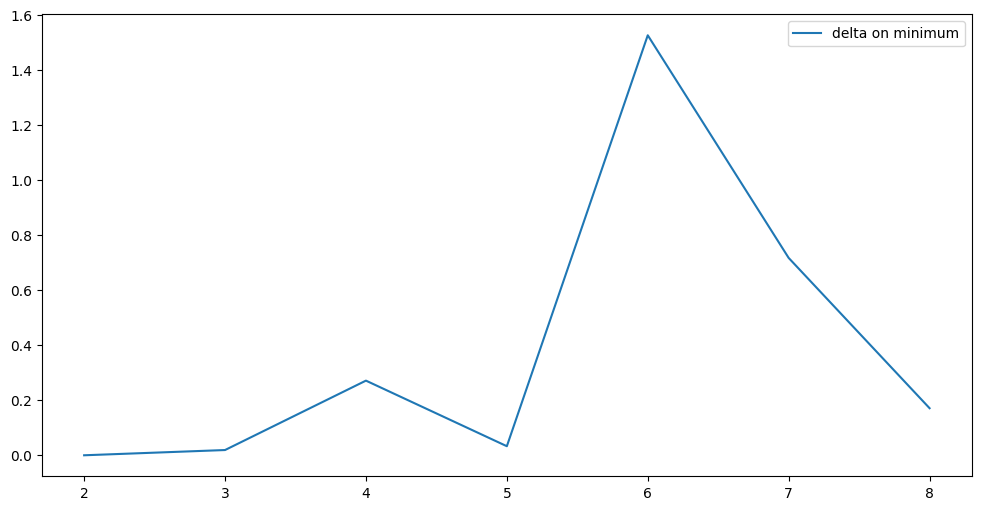

In [115]:

plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)

plt.plot(mean_res["delta_min_def"])
plt.legend(["delta on minimum"])
# mean_res.plot()

9.975526584935502e-05


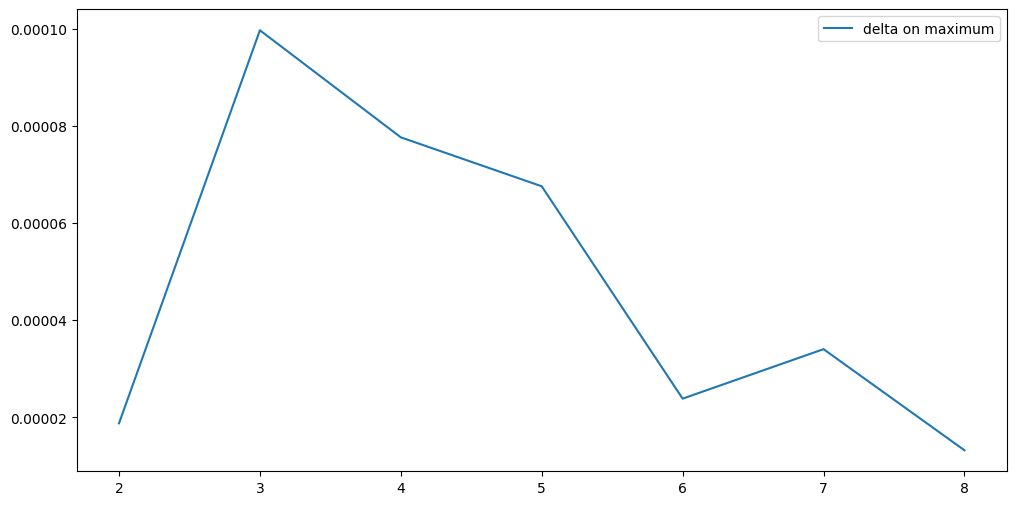

In [116]:
print(max(mean_res['delta_max']))
plt.figure(figsize=figsize)
plt.xticks(ticks=b_k)
plt.plot(mean_res["delta_max"])
plt.legend(["delta on maximum"])

<Figure size 1200x600 with 0 Axes>

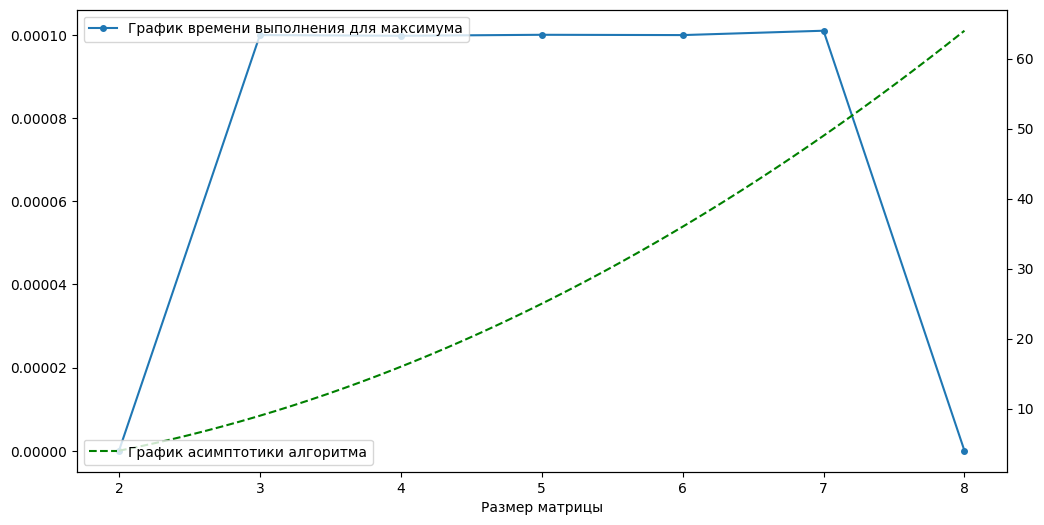

In [ ]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_res['value_max_time'],  marker='o',  markersize=4, label='График времени выполнения для максимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 2, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.show()
# plt.xticks(ticks=x)
# plt.legend(["time for calculation of maximum"])


<Figure size 1200x600 with 0 Axes>

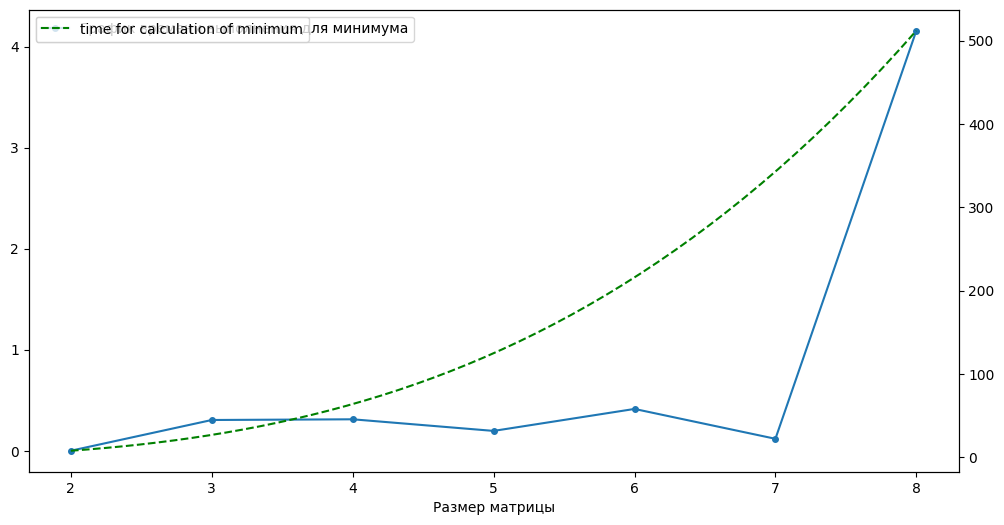

In [ ]:
plt.figure(figsize=figsize)

fig, ax1 = plt.subplots(figsize=figsize)

ax1.plot(mean_res['value_min_def_time'],  marker='o',  markersize=4, label='График времени выполнения для минимума')
ax1.set_xlabel('Размер матрицы')
ax1.set_xticks(b_k)

ax2 = ax1.twinx()

ax2.plot(x_lt, x_lt ** 3, color='green', linestyle='--', label='График асимптотики алгоритма')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
# plt.plot(x=x, y=x**2)
plt.legend(["time for calculation of minimum"])

In [119]:
# df.to_csv("data/df.csv")
# res_df.to_csv("data/res_df.csv")